In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
iris = datasets.load_iris() #Loading the dataset

# Convert dataset to Dataframe
df = pd.DataFrame(
        data= np.c_[iris['data'], iris['target']],
        columns= iris['feature_names'] + ['target']
        )

df
# From the dataset, we realize that for target variable.
# 0: 'Setosa'
# 1: 'versicolor'
# 2: 'virginica'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


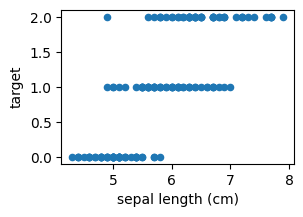

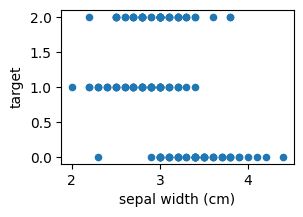

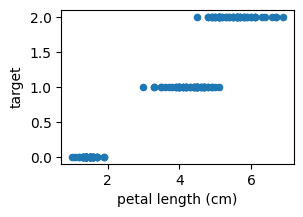

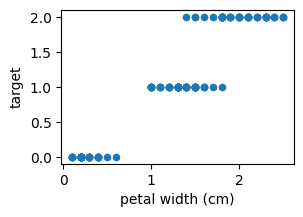

In [3]:
for column in df.columns:
    if column != "target":
        df.plot.scatter(x=column, y="target", figsize=(3, 2))

Froms plots, were not observed outliers
Also, from data, we don't observe that the target classes be unbalanced

In [4]:
y = df[['target']].astype(int)
X = df.drop(y, axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe = make_pipeline(StandardScaler(),
                     LinearDiscriminantAnalysis(),   #n_components <= min(n_classes - 1, n_features)
                     KNeighborsClassifier(n_jobs=-1),
                     )

Here, LinearDiscriminantAnalysis is used for dimensionality reduction, but it could be used as classifier directly.

In [30]:
param_lda_range = [1, 2]
param_lda_solver= ['svd', 'eigen']

param_knn_n_neighbors = [1, 2, 3, 4]
param_knn_weights = ['uniform', 'distance']

param_grid = [
              {'lineardiscriminantanalysis__n_components': param_lda_range,
               'lineardiscriminantanalysis__solver': ['svd'],
               'kneighborsclassifier__n_neighbors': param_knn_n_neighbors
               },  # Fisrt configuration
              {'lineardiscriminantanalysis__n_components': [2],
               'lineardiscriminantanalysis__solver': param_lda_solver,
               'kneighborsclassifier__n_neighbors': param_knn_n_neighbors,
               'kneighborsclassifier__weights': ['distance']
               }  # Second configuration
              ]

# In the previous grid, two configurations will be evaluated.

In [31]:
from sklearn.model_selection import GridSearchCV

# create grid to obtain the best hyperparams
search = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10,
                      refit=True,
                      n_jobs=-1)

search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lineardiscriminantanalysis',
                                        LinearDiscriminantAnalysis()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'kneighborsclassifier__n_neighbors': [1, 2, 3, 4],
                          'lineardiscriminantanalysis__n_components': [1, 2],
                          'lineardiscriminantanalysis__solver': ['svd']},
                         {'kneighborsclassifier__n_neighbors': [1, 2, 3, 4],
                          'kneighborsclassifier__weights': ['distance'],
                          'lineardiscriminantanalysis__n_components': [2],
                          'lineardiscriminantanalysis__solver': ['svd',
                                                                 'eigen']}],
             scoring='accuracy')

next, are obtained the mean and std of the score (accuracy) of the GRID (for the different configurations), NOT for the best model.

In [32]:
print(f'best params: {search.best_params_}')
print(f'best score:  {search.best_score_}')

cv_GridScore_mean = round( search.cv_results_["mean_test_score"].mean()*100 , 2)
cv_GridScore_std  = round( search.cv_results_["std_test_score"].mean()*100 , 2)

print(f'mean score: ({cv_GridScore_mean} +- {cv_GridScore_std})')

best params: {'kneighborsclassifier__n_neighbors': 3, 'lineardiscriminantanalysis__n_components': 1, 'lineardiscriminantanalysis__solver': 'svd'}
best score:  0.9666666666666668
mean score: (92.92 +- 7.8)


In [33]:
from sklearn.metrics import accuracy_score

# we pick the best estimator from the grid
best_estimator = search.best_estimator_

y_pred = best_estimator.predict(X_test)
accuracy_v1 = best_estimator.score(X_test, y_test)

# calculating throught the function
accuracy_v2 = accuracy_score(y_true=y_test, y_pred=best_estimator.predict(X_test))

print(accuracy_v1, accuracy_v2)

1.0 1.0


Both methods for calculate accuracy are equivalent.
Now, the cross validation (using bootstraping) will be calculated on the best model.

In [35]:
from sklearn.model_selection import cross_val_score

# The cross validation is applied on the training sample using the best model.
cv_score = cross_val_score(estimator=best_estimator, scoring='accuracy',
                           X=X_train, y=y_train.values.ravel(), cv=10, n_jobs=-1)

cv_score_mean = round( cv_score.mean()*100, 2 )
cv_score_std  = round( cv_score.std()*100,  2 )

print(f'({cv_score_mean} +- {cv_score_std})%')

(96.67 +- 6.67)%


If wished to obtain an evolution of the metric value (accuracy) as function of k neightbors

In [40]:
k_values = list(range(1, 100))
acc_mean = []
acc_std  = []

for k in k_values:

    pipe_ = make_pipeline(StandardScaler(),
                          LinearDiscriminantAnalysis(n_components=1, solver='svd'),
                          KNeighborsClassifier(n_neighbors=k, n_jobs=-1),
                          )

    # create grid to obtain the best hyperparams after using Scaling, PCA and finally SVC.
    score = cross_val_score(estimator=pipe_, scoring='accuracy',
                            X=X_train, y=y_train.values.ravel(), cv=10, n_jobs=-1)

    acc_mean.append( round( score.mean()*100, 2 ) )
    acc_std.append(  round( score.std()*100,  2 ) )

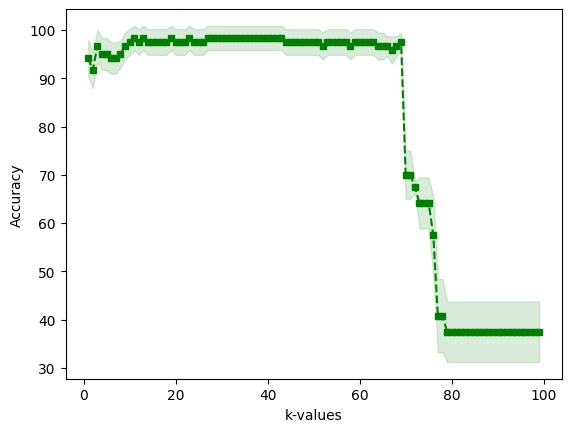

In [58]:
plt.plot(k_values, acc_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation (test) accuracy')

# 1-sigma uncertainty
plt.fill_between(k_values,
                 [mean + std/2 for mean, std in zip(acc_mean, acc_std)],
                 [mean - std/2 for mean, std in zip(acc_mean, acc_std)],
                 alpha=0.15, color='green')

plt.ylabel("Accuracy")
plt.xlabel("k-values")
plt.show()